# 21M.387 Fundamentals of Music Processing
## Pset 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp
import math 

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 3)

## Exercise 1

The data loaded below contains binary chord templates for 4 chords, arranged as a $4 \times 12$ matrix.

Identify each of the four chords. Hint - visualizing this matrix with `plt.imshow()` can be useful.

In [2]:
num_to_note_name = {0:'C',1:'C#',2:'D',3:'D#',4:'E',5:'F',6:'F#',7:'G',8:'G#',9:'A',10:'A#',11:'B'}
convert_to_note_name = np.vectorize(lambda x: num_to_note_name[x])

plt.imshow(some_chords)
#4,7,11 --> D
#3,7,10 --> 
#1,4,9  --> 
plt.figure()
indices = np.where(some_chords>0)[1].reshape(4,3)
notes = convert_to_note_name(indices)
chord_names = np.array([['E minor'],['D# major'],['A major'],['A# minor']])
print indices
print notes
print chord_names

NameError: name 'some_chords' is not defined

## Exercise 2

Write the function `harmonics_chord_template()` to create a _normalized_ chord template that contains energies in the first 8 harmonics of each note in the chord.

The harmonic energies of a given note should be proportional to $\alpha^n$ where $n$ is the harmonic number ($n=0$ is the fundamental, $n=1$ is the 2nd harmonic, etc...).

Inputs:

- pitches: a list of pitches to be included in the chord template
- alpha:  $\alpha$, the harmonic decay value

Outputs:
- a length 12 chorma template vector


In [3]:
some_chords = np.load('data/ex1.npy')

In [4]:
def f_to_midi(f):
    return 69.0 + 12*math.log(f/440.0,2)
def midi_to_f(midi):
    return 440.0*2**((midi - 69.0)/12.0)

def harmonics_chord_template(pitches, alpha): #assuming midi pitches
    bins = np.zeros(12)
    for pitch in pitches:
        for harmonic in range(1,8):
            delta_midi = int(round(12*math.log(harmonic,2)))
            bins[(pitch+delta_midi)%12] += alpha**harmonic
    return bins / np.linalg.norm(bins)

Use this function to create the chord templates for the following chords, using a harmonic decay value of $\alpha = 0.7$. 
- A minor
- F major
- E power chord (this is a chord of only two notes: the root and the fifth)

Print the results.

In [5]:
num_to_note_name = {0:'C',1:'C#',2:'D',3:'D#',4:'E',5:'F',6:'F#',7:'G',8:'G#',9:'A',10:'A#',11:'B'}
note_name_to_num = {v:k for k,v in num_to_note_name.iteritems()}
notes = [['C','E','G'],['A','C','E'],['F','A','C'],['E','B']]
chords = [[note_name_to_num[x] for x in y] for y in notes]
print chords

@interact(alpha=(0.1,1.0))
def template_with_decay(alpha=0.6):
    chord_templates = np.column_stack([harmonics_chord_template(chord,alpha)[:,None] for chord in chords])
    print chord_templates
    plt.imshow(chord_templates, origin='lower', cmap='Greys')
    plt.colorbar()
    plt.show()

[[0, 4, 7], [9, 0, 4], [5, 9, 0], [4, 11]]


interactive(children=(FloatSlider(value=0.6, description=u'alpha', max=1.0, min=0.1), Output()), _dom_classes=('widget-interact',))

## Exercise 3

In the following example, a simple template-based chord classifier is estimating chords in Bach's first prelude of the _Well-Tempered-Clavier_. The colored labels are as follows:
- TP: True Positive - the algorithm picked the correct chord
- FN: False Negative - shows the chord that should have been picked, but wasn't
- FP: False Positive - shows the incorrect chord that the algorithm picked 

<img src="images/bach_evaluation.png" width=700>

The algorithm is doing a good job in bars 1 and 4, but making more mistakes in bars 2 and 3. Why is this the case?

Answer:
Bach's Well-Tempered-Clavier is in the well-tempered tuning system. The well-tempered tuning system has relatively consistent (close to 3/2) perfect fifths, causing the ok readings in bars 1 and 4. Bars 2 and 3 have relatively strange intervals, and so taking the inner product yields relatively inconclusive results. 


## Exercise 4

Write the function `make_triads_templates()` to produce a chords template matrix with 24 rows where each row is a chord template:
- rows $[0-12]$ are the major triads (starting with __C__)
- rows $[13-24]$ are the minor triads (starting with __Cm__)

Use your function `harmonics_chord_template` from above.

Test your function with $\alpha = 0.6$ and plot the resulting matrix with `plt.imshow()`.

In [6]:
@interact(alpha=(0.1,1.0))
def make_triads_templates_test(alpha = 0.6):
    maj_indices = (np.arange(12)[:,None] + np.array([0,4,7]))%12
    min_indices = (np.arange(12)[:,None] + np.array([0,3,7]))%12
    chord_indices = np.concatenate([maj_indices, min_indices],axis=0)
    chord_templates = np.column_stack([harmonics_chord_template(chord,alpha)[:,None] for chord in chord_indices])
    plt.imshow(chord_templates, origin='lower', cmap='Greys')
    return chord_templates

def make_triads_templates(alpha):
    maj_indices = (np.arange(12)[:,None] + np.array([0,4,7]))%12
    min_indices = (np.arange(12)[:,None] + np.array([0,3,7]))%12
    chord_indices = np.concatenate([maj_indices, min_indices],axis=0)
    chord_templates = np.column_stack([harmonics_chord_template(chord,alpha)[:,None] for chord in chord_indices])
    return chord_templates
    

interactive(children=(FloatSlider(value=0.6, description=u'alpha', max=1.0, min=0.1), Output()), _dom_classes=('widget-interact',))

## Exercise 5a

Estimate the chords of the first 51 seconds of following song, _Here Comes the Sun_ by The Beatles, using the chords templates matrix you just created. The steps are:

- Create a normalized chromagram using $N=4096, H=2048, \gamma=1$. Use the provided function: `fmp.make_chromagram` and check the docstring to make sure you get the arguments right.
- Create the score matrix, showing how each chord template scores at every time step.
- Create the chord estimates array (call it `est`) by finding the index of the maximum value of the score matrix at each time step.
- Plot both the score matrix and the chord estimates array using `fmp.plot_matrix_and_points()`

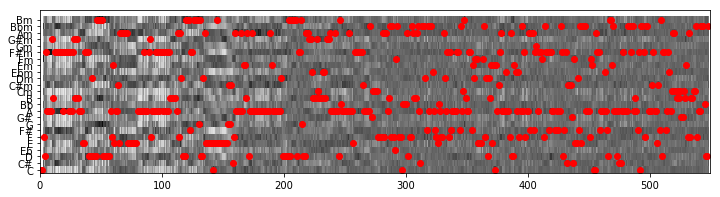

In [7]:
snd = load_wav("audio/beatles_here_comes_the_sun.wav",0, 51)
fs, fft_len, hop_size, gamma = 22050, 4096, 2048, 1
chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma, True)
chord_templates = make_triads_templates(0.6)
scores = np.dot(chord_templates.T,chroma)
est = np.argmax(scores, axis=0)
fmp.plot_matrix_and_points(scores, est)
fmp.chord_template_labels()


## Exercise 5b

Calculate the score of your chord estimates using the function you developed in Lab. For the ground truth set, use the file `"audio/beatles_here_comes_the_sun.lab"`. You can load the annotations file with `fmp.load_chord_annotation(filepath, ff)`

In [8]:
def calc_chord_score(est, gt):
    return sum([x==y for x,y in zip(est,gt[:len(est)])])/float(len(est))
def alt_calc_chord_score(est,gt):
    correct, total = sum([x==y for x,y in zip(est,gt[:len(est)])]), len(est)
    return (correct,total, correct/float(total))

ff = fs / hop_size
gt = fmp.load_chord_annotation("audio/beatles_here_comes_the_sun.lab", ff)
correct, total, score = alt_calc_chord_score(est,gt)
print 'Score = %d / %d = %.3f' % (correct, total, score)

#check
correct1, total1, score1 = fmp.get_score_stats(est, gt) #redo get score stats
print 'Score = %d / %d = %.3f' % (correct1, total1, score1)


Score = 102 / 549 = 0.186
Score = 102 / 549 = 0.186


## Exercise 6

One of reasons the score is so low in this example is that the Beatles played this song with a tuning that is different from $A4=440$.

There is an optional parameter in `fmp.make_chromagram()` for providing a tuning value. This is normally 0, but can be used to adjust the tuning of the chromagram by fractional semitones. For example, passing in the argument `tuning = -0.2` will create a chromagram that works well for instruments that play flat by 20 cents from $A4=440$. (Remember that 100 cents = 1 semitone).

Write the function below `calc_score_with_tuning()` that returns a score value, similarly to _Exercise 5_, but with "tuned chromagram". If you pass in a tuning value of 0, you should get same score as above.

Inputs:

- `snd`, the wave data
- `gt_file`, the ground truth annotations filename
- `tuning`, the tuning parameter for creating the chromagram

Output:
- the score of the chord estimation

Then, try a bunch tuning values in the range $[-0.5, +0.5]$ and see what tuning value produces the best chord score. You should write a function that does this as well.

Print the best tuning value as well as the score it generates.

Score = 141 / 549 = 0.257
best tuning: 0.285714285714
best score: 0.256830601093


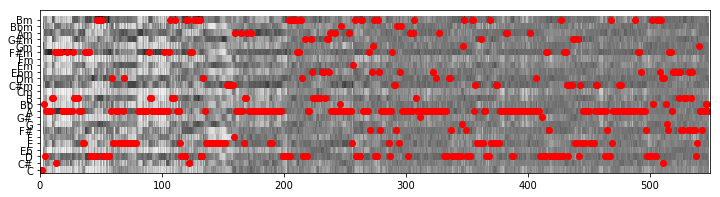

In [9]:
def calc_score_with_tuning(snd, gt_file, visualize, tuning=0):
    fs, fft_len, hop_size, gamma = 22050, 4096, 2048, 1
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma, True, tuning)
    chord_templates = make_triads_templates(0.6)
    scores = np.dot(chord_templates.T,chroma)
    est = np.argmax(scores, axis=0)
    if visualize:
        fmp.plot_matrix_and_points(scores, est)
        fmp.chord_template_labels()
    ff = fs / hop_size
    gt = fmp.load_chord_annotation("audio/beatles_here_comes_the_sun.lab", ff)
    correct, total, score = alt_calc_chord_score(est,gt)
    if visualize:
        print 'Score = %d / %d = %.3f' % (correct, total, score)
    return score
    
def find_best_tuning(test_tuning_vals):
    max_index = np.argmax([calc_score_with_tuning(snd,gt,False,tuning) for tuning in test_tuning_vals])
    best_tuning = test_tuning_vals[max_index]
    return (best_tuning, calc_score_with_tuning(snd,gt,True,best_tuning))

best_tuning, best_score = find_best_tuning(np.linspace(-0.5,0.5,15))
print "best tuning: "+str(best_tuning)
print "best score: "+str(best_score)

# test a number of different tuning values and find the best one.

## Exercise 7

Starting with the tuned chromagram (using the optimal tuning value from above), apply temporal smoothing using the `temporal_smoothing()` function you created in the Lab Exercise.

Try out different values of $L$, the smoothing window length, and find the value that works best for maximizing the resulting score from `calc_chord_score()`.

Finally, as suggested by Mitchell Gu in class, repeat this exercise with a Hanning window as opposed to a rectangular window. Modify the code to `temporal_smoothing()` by adding a third argument `window_type`.

Now find the best value of $L$ and the associated score using a Hanning window. Was Mitchell's guess correct that a Hanning can produce better results?

Score = 201 / 549 = 0.366
best window length: 19
best score: 0.366120218579
Score = 178 / 549 = 0.324
best score hanning: 0.324225865209
Did hanning window produce better results? False


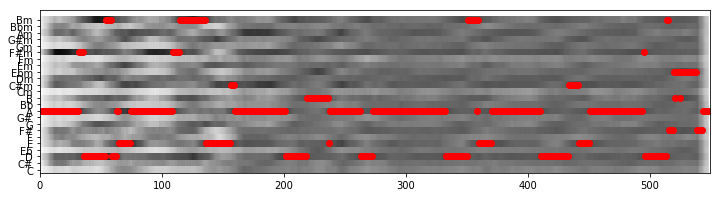

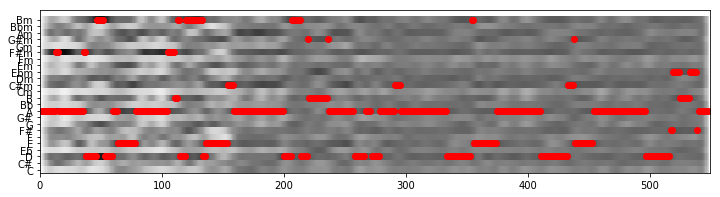

In [10]:
def temporal_smoothing(mtx, win_len, window_type='rect'): #mtx is the chromagram
    if window_type == 'rect':
        smoother = np.full(win_len,1.0/win_len)
    else: #hanning
        smoother = np.hanning(win_len)
    smoothed_mtx = np.apply_along_axis(lambda row: np.convolve(smoother,row,mode='same'), 1, mtx)
    return smoothed_mtx

def calc_score_with_smoothing_window(snd, gt_file, visualize, tuning, win_len, window_type):
    fs, fft_len, hop_size, gamma = 22050, 4096, 2048, 1
    chroma = temporal_smoothing(fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma, True, tuning),
                                win_len,window_type)
    chord_templates = make_triads_templates(0.6)
    scores = np.dot(chord_templates.T,chroma)
    est = np.argmax(scores, axis=0)
    if visualize:
        plt.figure()
        fmp.plot_matrix_and_points(scores, est)
        fmp.chord_template_labels()
    ff = fs / hop_size
    gt = fmp.load_chord_annotation("audio/beatles_here_comes_the_sun.lab", ff)
    correct, total, score = alt_calc_chord_score(est,gt)
    if visualize:
        print 'Score = %d / %d = %.3f' % (correct, total, score)
    return score

def find_best_smoothing_window(test_smoothing_windows,tuning, window_type):
    max_index = np.argmax([calc_score_with_smoothing_window(snd, gt, False, tuning, win_len, window_type) 
                            for win_len in test_smoothing_windows])
    best_win_len = test_smoothing_windows[max_index]
    return (best_win_len, calc_score_with_smoothing_window(snd, gt, True, tuning, best_win_len, window_type))

best_win_len, best_score = find_best_smoothing_window(np.arange(1,20),best_tuning,'rect')
print "best window length: "+str(best_win_len)
print "best score: "+str(best_score)

best_score_hanning = calc_score_with_smoothing_window(snd, gt, True, best_tuning, best_win_len, 'hanning')
print "best score hanning: "+str(best_score_hanning)

print 'Did hanning window produce better results? '+str(best_score_hanning>best_score)


## Exercise 8

Write the function `generate_markov_sequence` to generate a random sequence of states.

Inputs:
- `init_p`: initial probabilities (vector $C$)
- `trans_p`: transition probs (matrix $A$)
- `length`: length of sequence to generate    

Output:
- an `np.array` (of type `int`) representing the state 

Strategy:

- First generate the initial state (based on $C$).  
- Then generate the rest of the states in a loop (based on $A$)

I recommend looking at the function `np.random.choice` and looking closely at the optional input parameter `p`.

In [11]:
def generate_markov_sequence(init_p, trans_p, length): #C,A,length
    states = [np.random.choice(len(init_p),1,p=init_p)]
    for i in range(length-1):
        new_p = trans_p[states[-1]][0]
        states.append(np.random.choice(len(init_p),1,p=new_p))
    return np.concatenate(states)


Generate a sequence of length 30 with the markov parameters below.

Run this generating code multiple times. What do you notice about the sequences generated? Why does this happen?

In [12]:
C = np.array((.8, .2, 0))
A = np.array(((.8, .2, 0), (.1, .8, .1), (0, 0, 1.)))
print generate_markov_sequence(C, A, 30)

#states usually the same as the previous state because of high diagonal probabilities
#Rarely goes to state 2 because state 0 and 1 have low probabilites of switching to state 2
#When gets to state 2, stays permanently because 2 --> with 100% probability

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 2 2 2]


## Exercise 9

There are three probability sets that need to be defined for an HMM model:
- $C$, the initial probabilities vector for the hidden states
- $A$, the transition probabilities matrix for the hidden states
- $B$, the emissions probabilities matrix that relate hidden states to potential observations

Write the function `make_simple_trans_probs` to create $A$, the transition probabilities matrix for an HMM model with $I = 24$ states (12 major, 12 minor, as in lecture).  
- $A$ should have a large value on the diagonal (ie, self-transition probabilities)
- $A$ should have a small value everywhere else
- Specify the diagonal-to-non-diagonal value as a ratio (for example `diag_ratio=4` would have the diagonal values be 4x the other values).
- $A$ must be normalized so that rows add up to one (Manhattan norm, see Lab Exercise)


In [13]:
def L1_normalize_rows(mtx):
    return 1.0/(np.abs(mtx).sum(axis=1)[:,None])*mtx

def make_simple_trans_probs(diag_ratio):
    return L1_normalize_rows(np.ones((24,24))+np.eye(24)*(diag_ratio-1))


Create and plot this matrix for with diagonal ratios of 1, 5, and 20.  
The first one is already done for you below. Note the usage of `vmin=0, vmax=1` to force the display to show the full range of values $[0, 1]$.

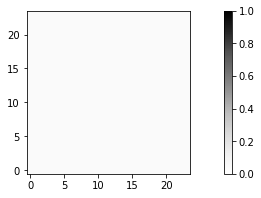

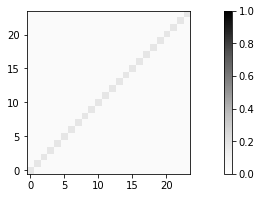

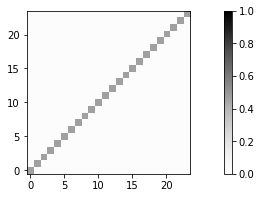

In [14]:
trans_probs = make_simple_trans_probs(1)
plt.figure()
plt.imshow(trans_probs, origin='lower', cmap="Greys", vmin=0, vmax=1)
plt.colorbar();

trans_probs = make_simple_trans_probs(5)
plt.figure()
plt.imshow(trans_probs, origin='lower', cmap="Greys", vmin=0, vmax=1)
plt.colorbar();

trans_probs = make_simple_trans_probs(20)
plt.figure()
plt.imshow(trans_probs, origin='lower', cmap="Greys", vmin=0, vmax=1)
assert trans_probs[0,0] == 20*trans_probs[0,1]
plt.colorbar();


## Exercise 10a

The code below sets up and performs an HMM estimation. The input to this function is the chromagram and the transition probabilities matrix, $A$.

In [15]:
from hmmlearn import hmm

def hmm_estimation(chroma, trans_probs):
    # create traids dictionary
    triads = fmp.make_triads_fb(0.6)
    
    # emission probabilities
    emis_probs = fmp.normalize_probs( np.dot(triads, triads.T) )
    
    # initial probabilities:
    init_probs = np.ones(24) / 24.

    # create observations:
    observations = np.argmax(np.dot(triads, chroma), axis=0)
    obs_column = observations.reshape(-1, 1)

    # create HMM model
    model = hmm.MultinomialHMM(n_components=24)
    model.transmat_ = trans_probs
    model.startprob_ = init_probs
    model.emissionprob_ = emis_probs
    
    # run HMM model:
    return model.decode(obs_column)[1]

Run this HMM estimator using:
- the tuned chromagram from Exercise 6 (chromagram with the tuning offset you found, but NOT temporally smoothed).
- the output of the function `make_simple_trans_probs` that you just created.

Try different values for `diag_ratio` until you find the best one (that maximizes the resultant score).

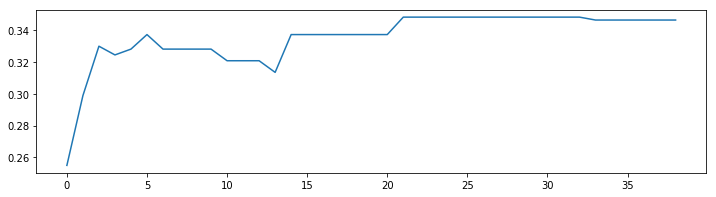

In [27]:
def create_hmm_estimation(diag_ratio = 1.0):
    trans_probs = make_simple_trans_probs(diag_ratio)
    fs, fft_len, hop_size, gamma = 22050, 4096, 2048, 1
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, gamma, True, best_tuning)
    est = hmm_estimation(chroma, trans_probs)
    #fmp.plot_matrix_and_points(scores, est)
    #fmp.chord_template_labels()
    ff = fs / hop_size
    gt = fmp.load_chord_annotation("audio/beatles_here_comes_the_sun.lab", ff)
    correct, total, score = alt_calc_chord_score(est,gt)
    #print 'Score = %d / %d = %.7f' % (correct, total, score)
    return score

scores = np.array([create_hmm_estimation(diag_ratio) for diag_ratio in range(1,40)])
plt.plot(scores)
#Best diag_ratio ~ 25

## Exercise 10b

- How do different values of of `diag_ratio` change the behavior of the HMM estimation?
- Why do some values of work better than others?

Answer:

If the diag_ratio is too small, the estimation will jump around more often than the annotation chords, leading to fewer matches. If it is too large, then the estimation will not change enough. Since changes happen relatively rarely, the score is relatively stable for values of diag_ratio higher than the correct amount.

The "correct amount" for the diag_ratio reflects the percentage of the time that chord annotation actually changes. 